<center> 

# **CASE STUDY: TTC STREETCAR DELAY - A DATA SCIENCE APPROACH**

***TABLE OF CONTENT:***

*I - DATA COLLECTION & ELT* (by Jay Menorca)

*II - DATA PRE-PROCESSING / FEATURE ENGINEERING* (by Ly Nguyen)

*III - ANALYSIS* (by Ly Nguyen) 

*- Hyperparameter Tuning*

*- Random Forest Classification* 

*- Model Evaluation*
    

*IV - INSIGHTS & DATA VISUALIZATION* (by XiaoXiao, Ly Nguyen )
 
*V - CONCLUSION* (by XiaoXiao, Ly Nguyen)

</center>

---
<center>

# **I - DATA COLLECTION / ELT** 
By: Jay Menarco.

</center>

**PRELIMINARY STEP: GITHUB REPOSITORY SETUP:**

- Github repository: jays-codes/team24
- Description: Main branch, developent branch, and release branch. 
- Each team member forks the repository (all branches), and worked (push/pull changes) on the development branch.

**DATA COLLECTION / ETL**

- Perform ETL (Extract, Load, Transform): 
    - Extract the following dataset, saved to SQLite database and Github repo: 
        - TTC Streetcar Delay, FY2023 and YTD-09-2024 (https://open.toronto.ca/dataset/ttc-streetcar-delay-data/): directly extracted to Github. 
    
    - Create the following datasets, save to SQLite database and/or Python dataframes and Github repository:  
        - Ontario Public Holiday, 2023 and 2024 (https://excelnotes.com/holidays-ontario-2023/ and https://excelnotes.com/holidays-ontario-2024): no file available, only information online. We manually created the datasets in .csv and saved to Github. 
        - Line route (https://www.ttc.ca/routes-and-schedules/listroutes/streetcar): no file available, only information online. We manually created the datasets in .csv and saved to Github.  
    
    - Load: 
        - Load the data to SQLite database 
        - From SQLite database, load to Python Panda dataframe. 
   
    - Transform: 
        - Join datasets to prepare for analysis: 
        - Perform some feature-engineering to prepare for analysis 
   


In [1]:
# Import necessary libraries for this notebook: 

# Read from SQLite database and load to a pandas dataframe
import os
import sqlite3
import pandas as pd

# For using arrays 
import numpy as np

# For ML work (data preprocessing, hyperparameter tuning, Random Forest Classifier, training & testing sets, and stratified sampling)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# For model evaluation, including explainability:  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import statsmodels.api as sm
import shap

# For data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# For saving the model into a pkl file
import joblib



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# *DATA COLLECTION & ELT*

**LOADING**

In [2]:
# Function to load data from SQLite database
def load_from_db(db_name, table_name):
    conn = sqlite3.connect(db_name)
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql(query, conn)
    conn.close()

    return df

In [3]:
# Set working directory to the notebook's directory
os.chdir(r"C:\Users\DELL\OneDrive\Desktop\SCHOOL\team24_ly\team24_ly")

# Now define your base directory relative to this location
base_dir = os.path.abspath(os.path.join(os.getcwd(), 'data'))
db_name = os.path.join(base_dir, 'streetcardelaydb2.db')

print(f"Database path: {db_name}")

# Check if the database file exists
if not os.path.exists(db_name):
    raise FileNotFoundError(f"Database file not found: {db_name}")

# Load data
table_name = 'Streetcar_Delay_Data'
df = load_from_db(db_name, table_name)


Database path: C:\Users\DELL\OneDrive\Desktop\SCHOOL\team24_ly\team24_ly\data\streetcardelaydb2.db


**TRANSFORMING**

In [4]:
# Convert incident_date to datetime format
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Load Date table to get holidayType columns
date_table_name = 'Date'
conn = sqlite3.connect(db_name)
date_df = pd.read_sql_query(f'SELECT * FROM {date_table_name}', conn)
date_df['date'] = pd.to_datetime(date_df['date'])

# Merge Date table with Streetcar_Delay_Data table on incident_date
df = df.merge(date_df[['date', 'holidayType']], left_on='incident_date', right_on='date', how='left')
df.drop(columns=['date'], inplace=True)

# Load Season table to get seasonType column
season_table_name = 'Season'
season_df = pd.read_sql_query(f'SELECT * FROM {season_table_name}', conn)
season_df['date'] = pd.to_datetime(season_df['date'])

# Merge Season table with Streetcar_Delay_Data table on incident_date
df = df.merge(season_df[['date', 'season']], left_on='incident_date', right_on='date', how='left')
df.rename(columns={'season': 'seasonType'}, inplace=True)
df.drop(columns=['date'], inplace=True)

# Load Line table to get lineId and lineName (no lineType)
line_table_name = 'Line'
line_df = pd.read_sql_query(f'SELECT * FROM {line_table_name}', conn)

# Merge the dataframes on lineId
df = df.merge(line_df[['lineId', 'lineName']], left_on='line', right_on='lineId', how='left')

# Load Delay table to get delayType
delay_table_name = 'Delay'
delay_df = pd.read_sql_query(f'SELECT * FROM {delay_table_name}', conn)

# Function to determine delayType
def get_delay_type(min_delay):
    for _, row in delay_df.iterrows():
        if row['delayFrom'] <= min_delay <= row['delayTo']:
            return row['delayId']
    return None

# Apply the function to determine delayType
df['delayType'] = df['min_delay'].apply(get_delay_type)

# Close the database connection
conn.close()

# Display the DataFrame
df.head()

,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,holidayType,seasonType,lineId,lineName,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,New Year's Day,Winter 2023,505,Dundas,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,New Year's Day,Winter 2023,504,King,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,New Year's Day,Winter 2023,504,King,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,New Year's Day,Winter 2023,510,Spadina,2
4,2023-01-01,506,06:35,Sunday,OSSINGTON STATION,Security,10,20,None,8706,New Year's Day,Winter 2023,506,Carlton,2


In [5]:
# Display exploratory statistics
df.describe()

,incident_date,min_delay,min_gap,delayType
count,21742,21742.000000,21742.000000,21742.000000
mean,2023-11-17 14:32:47.730659584,18.185494,27.249885,2.133014
min,2023-01-01 00:00:00,1.000000,0.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,2.000000
50%,2023-11-24 00:00:00,10.000000,20.000000,2.000000
75%,2024-04-15 00:00:00,15.000000,24.000000,2.000000
max,2024-09-30 00:00:00,960.000000,968.000000,3.000000
std,NaN,37.272247,39.340414,0.561122


--- 
<center>

# **DATA PRE-PROCESSING / FEATURE ENGINEERING** 

By: Ly Nguyen 

</center>

**- Exploratory data analysis**

- Assess min, max, quantiles, standard deviations of features
- Assess class imbalance
- Assess outliers 

**- Data Pre-processing:**

- Handle any NULL values, missing values, NA values, and zeros. 

- Select the response variable and the predictors:
    - Predictors:
        - Day (7 categories: Monday -> Sunday)

        - Holiday (12 unique values)

        - Season (7 categories: Spring 2023, Summer 2023, Autumn 2023, Winter 2023, Spring 2024, Summer 2024, Autumn 2024). 
        
            (*Note: the dataset is from Jan 2023 to Sep 2024 only.) 

        - Time (4 categories: morning peak (06:30 - 09:30), midday (10:00 - 14:00), evening peak (16:30 - 19:00), off peak (others))

        

        - Line (19 unique values)

        - Location (~3,000 unique locations)

        - Bound (4 unique categories: N, S, W, E)

        - Vehicle (~2,000 unique vehicle numbers)

        - Incident category (13 categories)


    - Response variable:
        - Delay time (3 categories: short delay (5 minutes or less), normal delay (between 6 and 15 minutes), long delay (16 minutes or more)) 

- Use Statistical Inference with visualization tools: 

    - Handle significant outliers 
    
- Feature engineering:
    - 'One hot encode' the features (over 4,300 features) 
    
    

# *EXPLORATORY ANALYSIS (EDA)* 


In [6]:
# Assess datatype and any NULL values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  21742 non-null  datetime64[ns]
 1   line           21698 non-null  object        
 2   incident_time  21742 non-null  object        
 3   day_of_week    21742 non-null  object        
 4   location       21741 non-null  object        
 5   incident       21742 non-null  object        
 6   min_delay      21742 non-null  int64         
 7   min_gap        21742 non-null  int64         
 8   bound          19127 non-null  object        
 9   vehicle        21742 non-null  object        
 10  holidayType    502 non-null    object        
 11  seasonType     21742 non-null  object        
 12  lineId         21580 non-null  object        
 13  lineName       21580 non-null  object        
 14  delayType      21742 non-null  int64         
dtypes: datetime64[ns](1

*Comment:*

-The dataset `df` contains 21,742 entries. 

1. **Null Values**:
   - Several columns contain null values:
     - `line` has 44 null values.
     - `location` has 1 null value.
     - `bound` has a significant number of null values (2,615).
     - `holidayType` has many null values, with only 502 non-null entries.
     - `lineId` and `lineName` also have null values (162 each).

2. **Data Types**:
   - `incident_date` is correctly in `datetime64[ns]` format.
   - `min_delay`, `min_gap`, and `delayType` are correctly in numerical integer formats.  
   - The rest is correctly stored as `object` format. 



*Note:* 

- When TTC streetcars are out of service and buses are used as substitutes, these buses are typically assigned the same route number as the streetcar line they are replacing. This helps passengers easily identify the substitute service and understand that it follows the same route as the regular streetcar service.

- For example, if a streetcar on route 509 Harbourfront is out of service, a bus might be assigned route number 509 to continue providing service along the same path.

- Therefore, we can drop the null values in 'line'.


In [7]:
# Count the unique values of each of the features
df.nunique()

incident_date     639
line               44
incident_time    1439
day_of_week         7
location         3197
incident           14
min_delay         268
min_gap           292
bound               8
vehicle          1578
holidayType         9
seasonType          8
lineId             17
lineName           12
delayType           3
dtype: int64

In [8]:
# Let's see why 'bound' has 8 unique values when it should only have 4 (N, S, W, E)
df['bound'].unique()


array(['W', 'E', 'S', None, 'N', 'B', '`', '1', '8'], dtype=object)

In [9]:
# Define the allowed values
allowed_bounds = ['N', 'S', 'W', 'E']

# Filter the DataFrame to keep only rows where 'bound' is in the allowed list
df = df[df['bound'].isin(allowed_bounds)]

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
df['bound'].unique()


array(['W', 'E', 'S', 'N'], dtype=object)

In [10]:
# Drop rows with null values in any column except 'holidayType'
df = df.dropna(subset=[col for col in df.columns if col != 'holidayType'])

# Confirm the remaining rows and null counts
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 18985 entries, 0 to 19108
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  18985 non-null  datetime64[ns]
 1   line           18985 non-null  object        
 2   incident_time  18985 non-null  object        
 3   day_of_week    18985 non-null  object        
 4   location       18985 non-null  object        
 5   incident       18985 non-null  object        
 6   min_delay      18985 non-null  int64         
 7   min_gap        18985 non-null  int64         
 8   bound          18985 non-null  object        
 9   vehicle        18985 non-null  object        
 10  holidayType    436 non-null    object        
 11  seasonType     18985 non-null  object        
 12  lineId         18985 non-null  object        
 13  lineName       18985 non-null  object        
 14  delayType      18985 non-null  int64         
dtypes: datetime64[ns](1), in

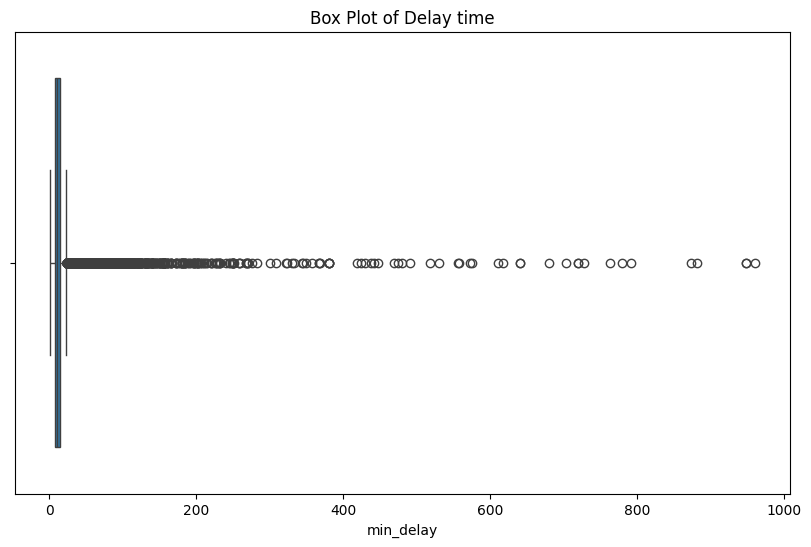

In [11]:
# Check for class imbalance with data visualization

# Whisker plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['min_delay'])
plt.title('Box Plot of Delay time')
plt.show()

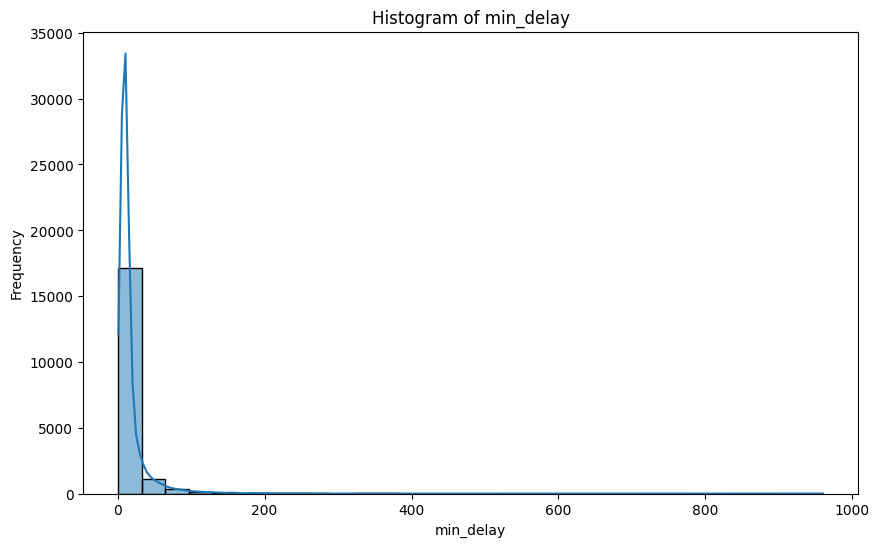

In [12]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['min_delay'], bins=30, kde=True)
plt.title('Histogram of min_delay')
plt.xlabel('min_delay')
plt.ylabel('Frequency')
plt.show()

In [13]:
# View the largest min_delay values - which are most likely outliers 
df['min_delay'].nlargest(20)


4744     960
4530     948
4550     948
4506     882
16055    873
15955    792
4761     780
170      763
4240     728
3018     720
3972     720
18556    703
15956    680
4421     641
13218    640
5351     618
15680    611
1020     575
5737     573
14167    558
Name: min_delay, dtype: int64

In [14]:
# Save down this "df" as a parquet file (to be used for separate EDA)  
df.to_parquet('df.parquet', engine='pyarrow', index=False)



### *Note:*

**Exploratory Data Analysis (EDA):** 

- Please refer to the EDA.ipynb for the visualizations.

- After exploring several 'number of classes' (between 2 to 6 classes) and 'delay buckets' (varying between 10 minutes and 20 minutes), and fitting a Random Forest Classifier on them:

- The optimal number of classes is 3, and the optimal 'delay buckets' are as follows:
  - Short delay (5 minutes or less)
  - Normal delay (between 6 and 15 minutes)
  - Long delay (16 minutes or more)

- This has been reflected accordingly in the "createLINETable.py" script, and consequently, the "streetcardelaydb2.db" database.

**Measurement Error and Recall Bias:**

- As observed in the EDA.ipynb file, there is likely significant recall bias in the data collection process, where it seems that data collectors/reporters estimated delay minutes rather than using a system/algorithm to 'start' and 'stop' the clock counts when a delay event occurs.
- For example, there are large volumes of exactly 5-minute, 10-minute, and 15-minute delays, with a notable drop in volumes for the minutes in between.
- We could verify this assumption with the TTC.
- If this is the case, it is also highly likely that many significantly long delays—up (to 15 hours) — may be due to recall bias rather than actual 'start' and 'stop' clock counts, exacerbating measurement error and reducing data quality.


**Approach:**

- Due to the recall bias and measurement error mentioned, using regression would most likely result in a poor fit, as it tries to accurately predict numbers from data that were likely roughly estimated.
- We will select a classification model and choose an ensemble bagging method for this problem — in particular, the Random Forest Classifier.




### **Observation:**

- Most of the delay time observations fall within 15 minutes (as shown in the boxplot).
- There are many outliers outside of 15 minutes, extending as far as 900 minutes.
- The data distribution is skewed to the right.
- We have several options to approach this case study:
  - Option 1: Focus the analysis on the most frequently encountered delays, i.e., within 15 minutes.
  - Option 2: Focus the analysis on the most disruptive and significant delays, i.e., above 600 minutes.
  - Option 3: Include all data points to have a general view and accept the possibility of a less accurate prediction.


**Approach:**

- For this project scope, we choose **Option 3: to have a general view, accepting the possibility of a less accurate prediction**.
- We try to minimize inaccuracies as much as possible for Option 3 by:
  - Using a classifier to define classes of 'frequent delays' (delays within 15 minutes) and 'disruptive/significant delays' (delays longer than 15 minutes), and employing a Random Forest Classifier as it is generally robust with outliers.
    - Delay Type 1 - Short delay: 5 minutes or less
    - Delay Type 2 - Normal delay: between 6 and 15 minutes
    - Delay Type 3 - Long delay: over 15 minutes

  - Reducing the dataset to delays that are less than 1 hour.

- (Remark: Option 1 and Option 2 are *out of scope* but can be studied separately in the future.)



In [15]:
# Create a new DataFrame with min_delay values less than 60 minutes
df_new = df[df['min_delay'] < 61]

# Display the new DataFrame
df_new.head()



,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,holidayType,seasonType,lineId,lineName,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,New Year's Day,Winter 2023,505,Dundas,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,New Year's Day,Winter 2023,504,King,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,New Year's Day,Winter 2023,504,King,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,New Year's Day,Winter 2023,510,Spadina,2
4,2023-01-01,501,08:52,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,20,W,8015,New Year's Day,Winter 2023,501,Queen,2


In [16]:
df_new.describe()

,incident_date,min_delay,min_gap,delayType
count,18234,18234.000000,18234.000000,18234.000000
mean,2023-11-18 08:59:18.538993152,12.878469,21.901338,2.086377
min,2023-01-01 00:00:00,1.000000,0.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,2.000000
50%,2023-11-25 00:00:00,10.000000,20.000000,2.000000
75%,2024-04-17 00:00:00,12.000000,21.000000,2.000000
max,2024-09-30 00:00:00,60.000000,224.000000,3.000000
std,NaN,9.842077,12.129825,0.540518


In [17]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18234 entries, 0 to 19108
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  18234 non-null  datetime64[ns]
 1   line           18234 non-null  object        
 2   incident_time  18234 non-null  object        
 3   day_of_week    18234 non-null  object        
 4   location       18234 non-null  object        
 5   incident       18234 non-null  object        
 6   min_delay      18234 non-null  int64         
 7   min_gap        18234 non-null  int64         
 8   bound          18234 non-null  object        
 9   vehicle        18234 non-null  object        
 10  holidayType    425 non-null    object        
 11  seasonType     18234 non-null  object        
 12  lineId         18234 non-null  object        
 13  lineName       18234 non-null  object        
 14  delayType      18234 non-null  int64         
dtypes: datetime64[ns](1), in

# DATA PRE-PROCESSING / FEATURE ENGINEERING

- Featurize the time types 
- Clean values within the reduced dataset 
- One-hot-encode the features 

In [18]:
# Ensure consistent parsing of datetime
df_new['incident_time'] = pd.to_datetime(
    df_new['incident_time'], 
    format='%H:%M',  # Adjust format based on time data (e.g., 'HH:MM')
    errors='coerce'
).dt.time

# Define function to categorize time
def categorize_time(time):
    if pd.isna(time):
        return None
    if pd.to_datetime('06:30').time() <= time <= pd.to_datetime('09:30').time():
        return 'morning_peak'
    elif pd.to_datetime('10:00').time() <= time <= pd.to_datetime('14:00').time():
        return 'midday'
    elif pd.to_datetime('16:30').time() <= time <= pd.to_datetime('19:00').time():
        return 'evening_peak'
    else:
        return 'off_peak'

# Apply function to create new column "timeType"
df_new = df_new.copy()  # Ensure df_new is independent
df_new['timeType'] = df_new['incident_time'].apply(categorize_time)

# Define a helper function for cleaning columns
def clean_column(df, column_name, valid_values=None):
    # Work on a copy of the DataFrame
    cleaned_df = df.copy()
    
    # Remove leading/trailing spaces
    cleaned_df.loc[:, column_name] = cleaned_df[column_name].str.strip()
    
    # Drop rows with null values in the specified column
    cleaned_df = cleaned_df[cleaned_df[column_name].notna()]
    
    # Filter rows by valid values if provided
    if valid_values:
        cleaned_df = cleaned_df[cleaned_df[column_name].isin(valid_values)]
    
    return cleaned_df

# Initialize df_cleaned as a copy of df_new
df_cleaned = df_new.copy()

# Clean columns
columns_to_clean = ['location', 'incident', 'vehicle', 'day_of_week', 'line', 'bound']
for col in columns_to_clean:
    df_cleaned = clean_column(df_cleaned, col)

# Recreate df_cleaned to ensure independence
df_cleaned = df_cleaned.copy()

# One-Hot Encode Categorical Columns
categorical_cols = ['location', 'incident', 'vehicle', 'day_of_week', 'line', 'bound', 'timeType', 'holidayType', 'seasonType']

# Use pandas get_dummies to one-hot encode the categorical columns
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
# Display the DataFrame after one-hot encoding
df_cleaned.head()


,incident_date,incident_time,min_delay,min_gap,lineId,lineName,delayType,location_1 DAVIES AVE,location_10 RITCHIE AVE,location_100 KING ST W,...,holidayType_New Year's Day,holidayType_Thanksgiving,holidayType_Victoria Day,seasonType_Fall 2024,seasonType_Spring 2023,seasonType_Spring 2024,seasonType_Summer 2023,seasonType_Summer 2024,seasonType_Winter 2023,seasonType_Winter 2024
0,2023-01-01,02:40:00,15,25,505,Dundas,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
1,2023-01-01,02:52:00,10,20,504,King,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
2,2023-01-01,02:59:00,25,35,504,King,3,False,False,False,...,True,False,False,False,False,False,False,False,True,False
3,2023-01-01,05:38:00,15,30,510,Spadina,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False
4,2023-01-01,08:52:00,10,20,501,Queen,2,False,False,False,...,True,False,False,False,False,False,False,False,True,False


In [20]:
print(df_cleaned.dtypes)  # This should show only numeric data types



incident_date             datetime64[ns]
incident_time                     object
min_delay                          int64
min_gap                            int64
lineId                            object
                               ...      
seasonType_Spring 2024              bool
seasonType_Summer 2023              bool
seasonType_Summer 2024              bool
seasonType_Winter 2023              bool
seasonType_Winter 2024              bool
Length: 4400, dtype: object


In [21]:
# As there are 4,400 features, we will need to save the output to a .txt file and verify that the data types are correct.
with open("data_types_output.txt", "w") as file:
    file.write(df_cleaned.dtypes.to_string())


In [22]:
# Checking the data distribution of the cleaned dataset 
df_cleaned.describe()

,incident_date,min_delay,min_gap,delayType
count,18234,18234.000000,18234.000000,18234.000000
mean,2023-11-18 08:59:18.538993152,12.878469,21.901338,2.086377
min,2023-01-01 00:00:00,1.000000,0.000000,1.000000
25%,2023-06-13 00:00:00,8.000000,16.000000,2.000000
50%,2023-11-25 00:00:00,10.000000,20.000000,2.000000
75%,2024-04-17 00:00:00,12.000000,21.000000,2.000000
max,2024-09-30 00:00:00,60.000000,224.000000,3.000000
std,NaN,9.842077,12.129825,0.540518


In [23]:
# Drop the following columns: incident_date, incident_time, min_gap, lineID. lineName
df_cleaned = df_cleaned.drop(['incident_date','incident_time', 'min_gap', 'lineId', 'lineName'], axis=1)


In [24]:
# Check the distribution of delayType
print(df_cleaned['delayType'].value_counts())

delayType
2    12771
3     3519
1     1944
Name: count, dtype: int64


# *ASSESSING CLASS IMBALANCE*



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



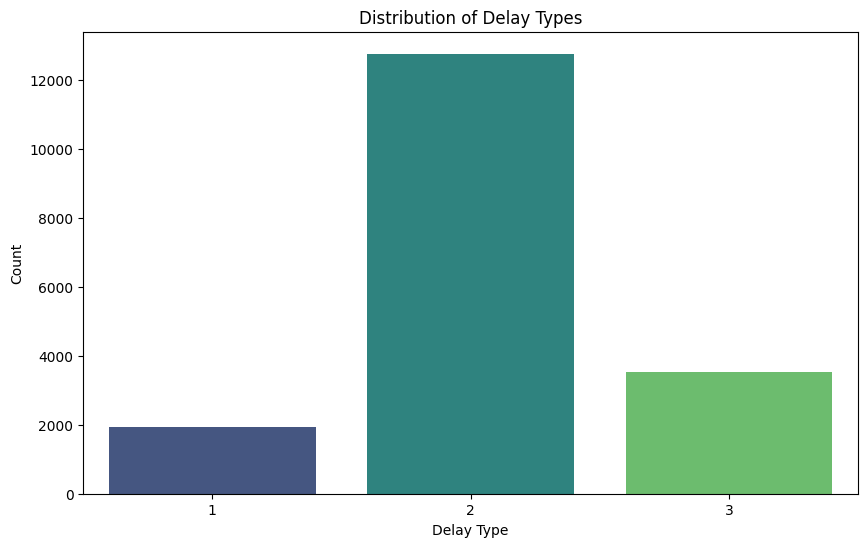

In [25]:
# Visualize this with a whisker plot:
delay_type_counts = df_cleaned['delayType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=delay_type_counts.index, y=delay_type_counts.values, palette='viridis')
plt.title('Distribution of Delay Types')
plt.xlabel('Delay Type')
plt.ylabel('Count')
plt.show()


**Observation:**
- There is a significant class imbalance (as expected), where the normal delay type (between 6 and 15 minutes) significantly dominates.
- This means we will need to employ stratified sampling during cross-validation (to ensure representative subsets), balanced class weight, and balanced accuracy score to ensure a predictive model that doesn't bias the majority class too much.


In [26]:
# Save down this "df_cleaned" as a parquet file (to be used for multiple ML experimentation)
df_cleaned.to_parquet('df_cleaned.parquet', engine='pyarrow', index=False)

--- 
<center>

# **ANALYSIS**
by: Ly Nguyen

<center>

# *PREDICTIVE METHOD: RANDOM FOREST CLASSIFIER* 

**SETTING TRAINING & TEST SETS** 

In [27]:
# Define X and y: 
X = df_cleaned.drop(columns=['min_delay', 'delayType']) 
y = df_cleaned['delayType']

In [28]:
# As there are ~ 4,400 features, we will need to save the X (predictors) matrix to a .txt file and verify that everything is okay (e.g., features, data types)
# Save column data types to a text file
with open("X_data_types_output.txt", "w") as file:
    file.write(X.dtypes.to_string())

In [29]:

# Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Convert y_train to integer if it’s categorical
y_train = y_train.astype(int)

In [79]:
# Save a DataFrame to a parquet file - for other ML experimentation
X_train.to_parquet('X_train.parquet')
y_train.to_csv('y_train.csv')



**STRATIFIED SAMPLING & PARAMETER TUNING**

As there is a significant class imbalance, we will:
- Set stratified sampling for the training set.
- Set balanced class weight.
- Choose balanced accuracy score as the main scoring metric.

Then we will:
- Manually tune for `max_depth` and the number of trees (`n`).
    - *Note: Although this can be done automatically with Grid Search, manually tuning the parameters allows us to observe how the scoring metric changes with varying parameters.*

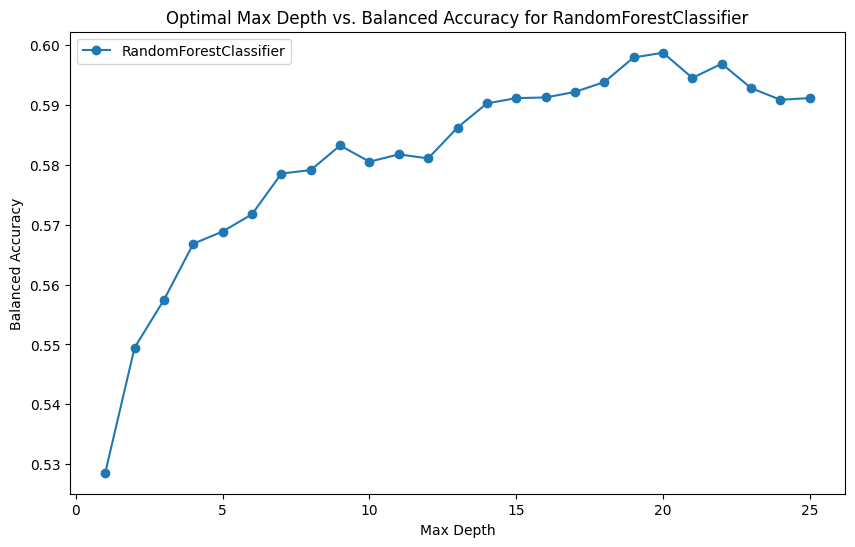

In [30]:
# Set up stratified cross-validation on the training set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Tune max_depth on the training set using stratified cross-validation
max_depth_range = range(1, 26)
balanced_accuracy_depth = []

for max_depth in max_depth_range:
    rf_temp = RandomForestClassifier(max_depth=max_depth, class_weight='balanced', random_state=42)
    # Perform cross-validation with balanced accuracy scoring
    scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
    mean_score = scores.mean()
    balanced_accuracy_depth.append(mean_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, balanced_accuracy_depth, label="RandomForestClassifier", marker='o')
plt.title("Optimal Max Depth vs. Balanced Accuracy for RandomForestClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Observation:*

- The optimal max_depth is between 18 and 20

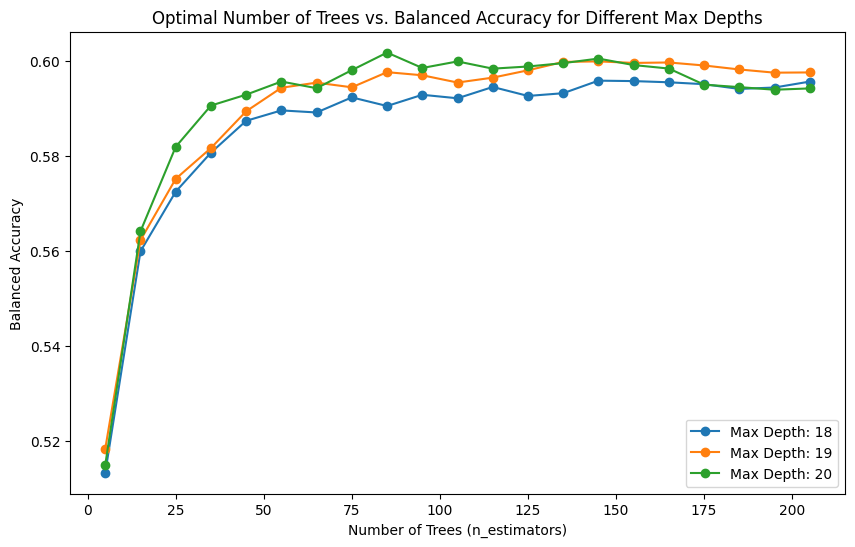

In [32]:
# Tune both max_depth and n_estimators on the training set using stratified cross-validation
max_depth_range = [18, 19, 20]  # Limited max_depth range for faster tuning
n_estimators_range = range(5, 210, 10)  # Range for n_estimators
results = []  # To store results for each combination

for max_depth in max_depth_range:
    balanced_accuracy_scores = []
    for n_estimators in n_estimators_range:
        rf_temp = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', random_state=42)
        # Perform cross-validation with balanced accuracy scoring
        scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
        mean_score = scores.mean()
        balanced_accuracy_scores.append(mean_score)
    
    # Store results for this max_depth
    results.append((max_depth, balanced_accuracy_scores))

# Plot the results for each max_depth
plt.figure(figsize=(10, 6))
for max_depth, scores in results:
    plt.plot(n_estimators_range, scores, label=f"Max Depth: {max_depth}", marker='o')

plt.title("Optimal Number of Trees vs. Balanced Accuracy for Different Max Depths")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Observation:*
= The optimal number of 'n' is between 80 and 90 trees, at optimal max-depth value of 20. 

In [36]:
# Define the parameter grid with max_depth fixed at 10
param_grid = {
    'n_estimators': [80, 85, 90],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}


# Initialize the Random Forest Classifier with fixed max_depth
clf = RandomForestClassifier(max_depth=20, class_weight='balanced', random_state=42)

# Initialize StratifiedKFold for stratified cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with StratifiedKFold
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=stratified_cv,
    scoring='balanced_accuracy',
    n_jobs=-1
)


# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 85}


In [37]:
best_params = {
    'min_samples_leaf': 1,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 2,  # Minimum number of samples required to split an internal node
    'n_estimators': 85,  # Number of trees in the forest
     'max_depth': 20  # Minimum number of samples required to split an internal node
}

# Initialize and fit the Random Forest Classifier with updated best parameters
best_clf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=85,
                       random_state=42)

In [38]:
# Fit the model on the test set
y_pred = best_clf.predict(X_test)



In [39]:
# Get the feature importances
feature_importances = best_clf.feature_importances_

# Use the feature names from the preprocessed data
features = X.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                                Feature  Importance
2823                 incident_Diversion    0.093264
4371                           line_512    0.076124
2829                incident_Mechanical    0.051701
4377                  timeType_off_peak    0.030017
2822  incident_Collision - TTC Involved    0.026492
...                                 ...         ...
2104    location_QUEEN ST W AND BATHURS    0.000000
2105    location_QUEEN ST W AND BEATY A    0.000000
2106    location_QUEEN ST W AND BROCK A    0.000000
2107    location_QUEEN ST W AND DUFFERI    0.000000
0                 location_1 DAVIES AVE    0.000000

[4393 rows x 2 columns]


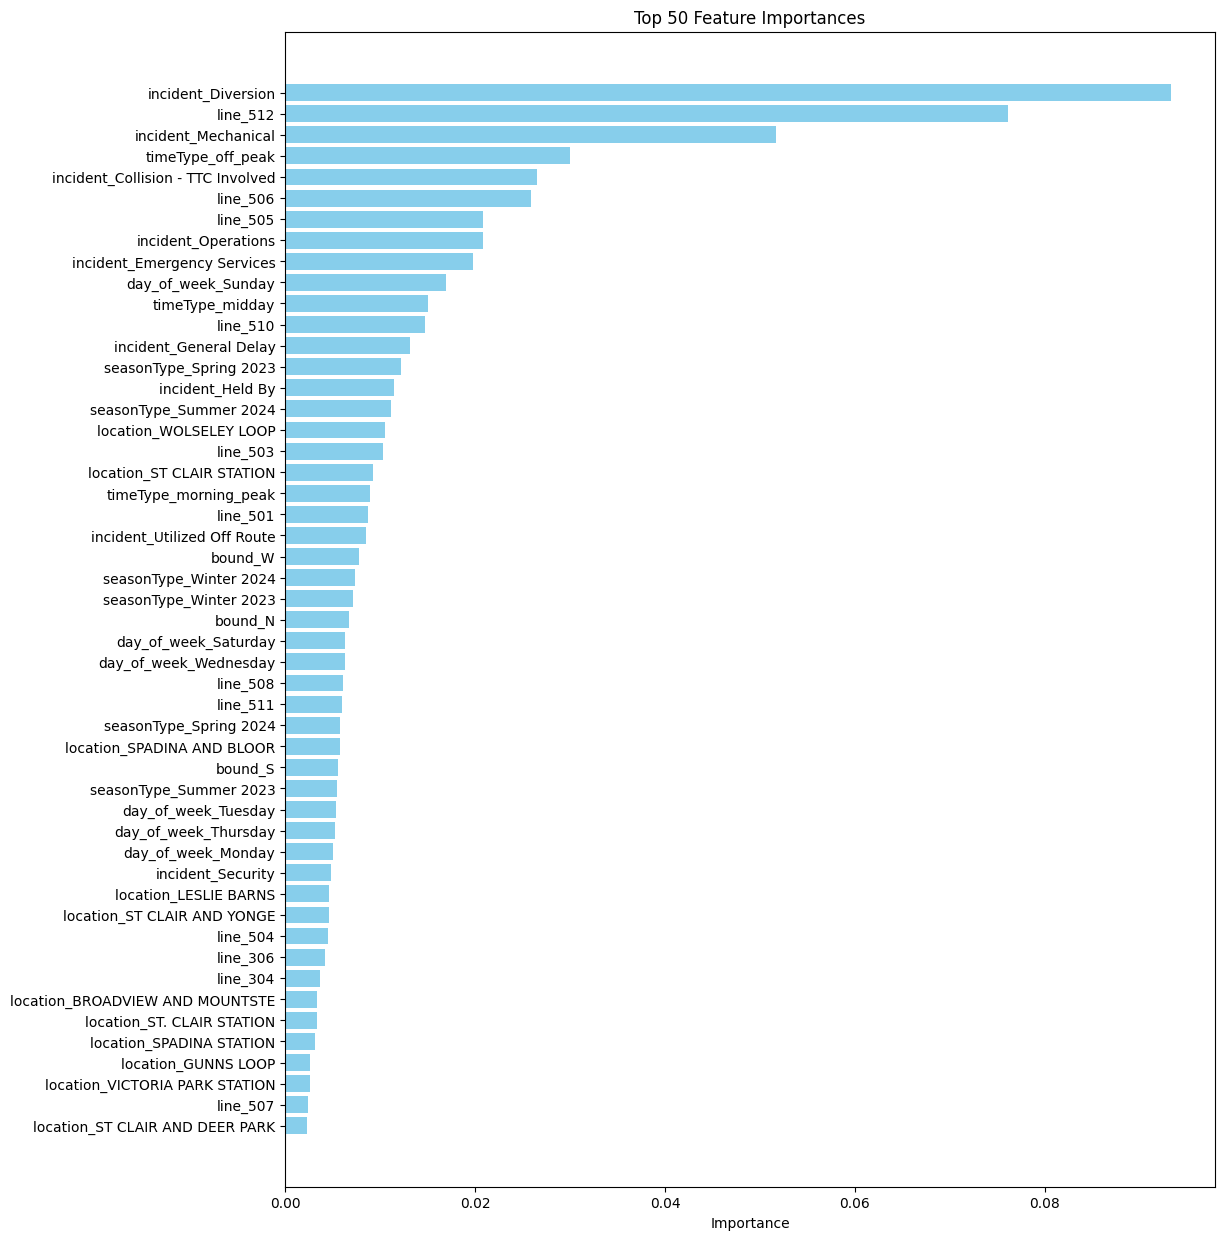

In [40]:
# Select the top features
top_features = importance_df.head(50)

# Plot the top 200 feature importances
plt.figure(figsize=(12, 15))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 50 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


---
# *MODEL PERFORMANCE EVALUATION*

In [41]:
# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate and print the balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.34      0.59      0.44       583
           2       0.82      0.59      0.69      3832
           3       0.37      0.60      0.46      1056

    accuracy                           0.59      5471
   macro avg       0.51      0.59      0.53      5471
weighted avg       0.68      0.59      0.61      5471


Balanced Accuracy: 0.59


### **INTERPRETATION:**

- **Balanced Accuracy:** The model performs above average, with **59%** of the predictions made by the model are correct. 

- **Precision, Recall, and F1-score (ie. the harmonic mean of precision and recall):** 
    
    - **Precision scores**: 
    
        - The model performs poorly for the minority classes: 34% for the Delay Type 1 (short delays <=5 minutes>), and 37% for  the Delay Type 3 (long delays >=16 minutes)
        
        - However, the model performs well for the majority class - 83% for the Delay Type 2 (normal delays, between 6 and 15 minutes). 
        
        - This means that there are many false positives for the minority classes (Delay Types 1 and 3). 

    - **Recall scores**: Above average scores across the classes (59%, 59% and 60% for Delay Type 1, 2 and 3 respectively). This means there are many missed true positive cases. 
       
    - **F1 scores**: Poor scores for the minority classes - 44% for the Delay Type 1, and 46% for  the Delay Type 3 -  but performs acceptably for the majority class - 69% for the Delay Type 2. This means that the model is not effective at correctly identifying positive instances while minimizing false positives - especially for the minority classes. 




## SHAP (Explainability)

In [42]:
# Create a SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_clf)

# Calculate SHAP values
# For classifiers, shap_values is a list of arrays (one per class)
shap_values = explainer.shap_values(X_test)


In [43]:
# SHAP values for delayType = 1
shap_values_class1 = shap_values[0]

# SHAP values for delayType = 2
shap_values_class2 = shap_values[1]

# SHAP values for delayType = 3
shap_values_class3 = shap_values[2]


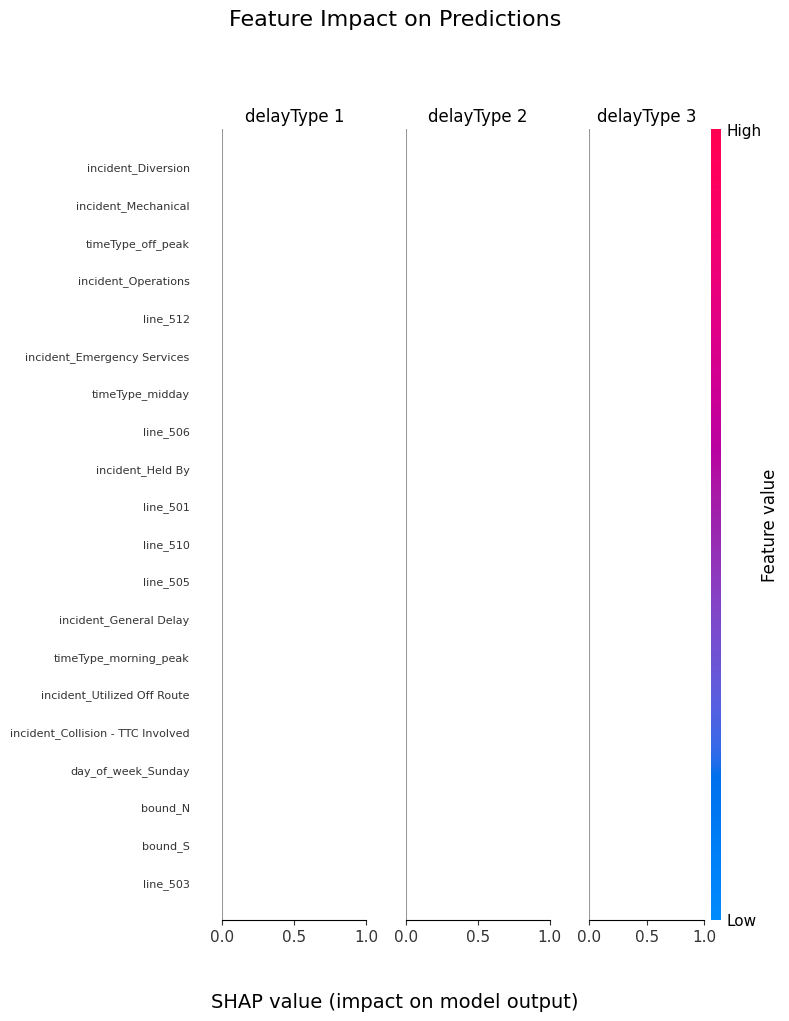

In [44]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)  # 1 row, 3 columns

# Beeswarm plot for delayType = 1
plt.sca(axes[0])  # Set the current axis to the first subplot
shap.summary_plot(shap_values_class1, X_test, plot_type="beeswarm", show=False, color_bar=False)  # Hide color bar
axes[0].set_title("delayType 1", fontsize=12)
axes[0].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[0].set_xlabel("")  # Remove X-axis label

# Beeswarm plot for delayType = 2
plt.sca(axes[1])  # Set the current axis to the second subplot
shap.summary_plot(shap_values_class2, X_test, plot_type="beeswarm", show=False, color_bar=False)  # Hide color bar
axes[1].set_title("delayType 2", fontsize=12)
axes[1].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[1].set_xlabel("")  # Remove X-axis label

# Beeswarm plot for delayType = 3
plt.sca(axes[2])  # Set the current axis to the third subplot
shap.summary_plot(shap_values_class3, X_test, plot_type="beeswarm", show=False)  # Keep color bar
axes[2].set_title("delayType 3", fontsize=12)
axes[2].tick_params(axis='y', labelsize=8)  # Make Y-axis fonts smaller
axes[2].set_xlabel("")  # Remove X-axis label

# Add a centered title above all subplots
fig.suptitle("Feature Impact on Predictions", fontsize=16, y=1)  # Adjust y for better spacing

# Add a single label below the x-axes
fig.text(0.5, -0.05, "SHAP value (impact on model output)", ha='center', fontsize=14)

# Adjust layout for better readability
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to leave space for the suptitle
plt.show()


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


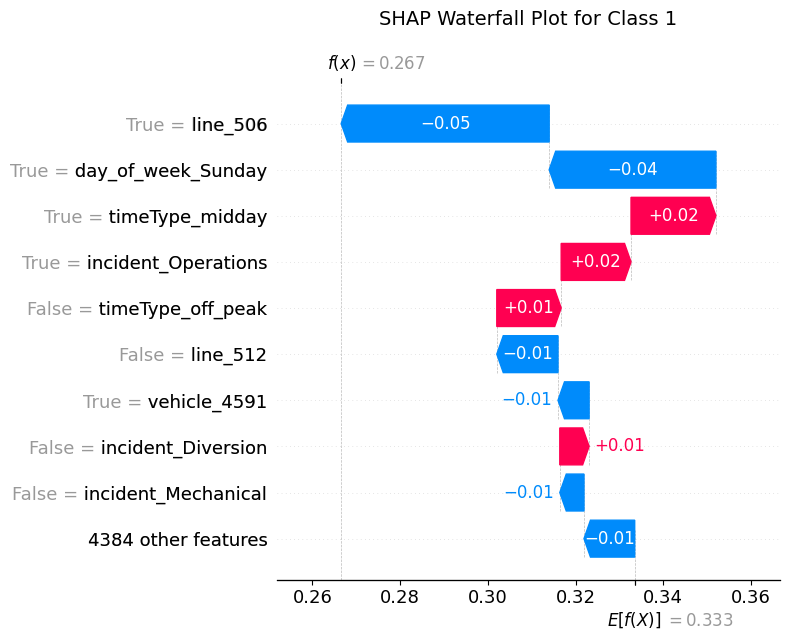

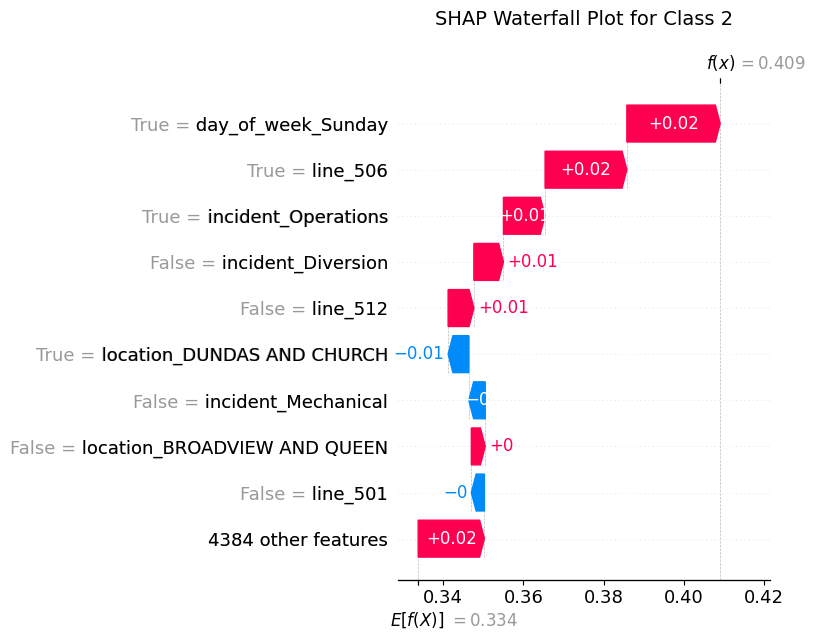

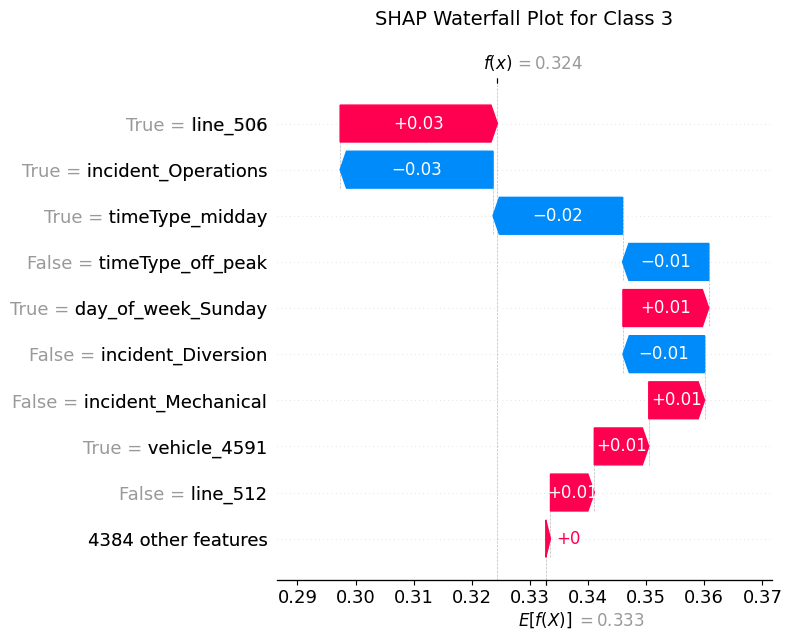

In [45]:
# Sample index for demonstration
sample_index = 0

# Store shap values for the 3 classes in a list of arrays
shap_values_list = [shap_values_class1, shap_values_class2, shap_values_class3]

# Iterate through each class to create waterfall plots
for i in range(len(shap_values_list)):
    shap_values_class = shap_values_list[i]
    
    # Create SHAP explanation object for the current class
    explanation = shap.Explanation(
        values=shap_values_class[sample_index],
        base_values=explainer.expected_value[i],  # Base value for the current class
        data=X_test.iloc[sample_index],
        feature_names=X_test.columns
    )
    
    # Generate the waterfall plot with a title directly inside the plot
    plt.figure(figsize=(8, 6))  # Optional: Set figure size
    shap.waterfall_plot(explanation, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot for Class {i+1}", fontsize=14, pad=20)  # Add a title to the plot
    plt.tight_layout()  # Ensure layout fits well
    plt.show()  # Display the plot


### **INTERPRETATION:**

#### **Delay Type 1:**
- The final predicted value is **0.267**, lower than the baseline (0.333).

- Positive influential features:
  - Time types Midday and Off-Peak: Improve the prediction by +0.02 and +0.01 respectively.
  - Incident types Operations and Diversion: Improve the prediction by +0.02 and +0.01 respectively.

- Negative influential features:
  - Lines 506 and 512: Reduce the prediction by -0.05 and -0.01 respectively.
  - Sunday: Reduces the prediction by -0.04. 
  - Vehicle 4591: Reduces the prediction by -0.01
  - Incident Mechanical: Reduces the prediction by -0.01



#### **Delay Type 2:**
- The final predicted value is **0.409**, slightly higher than the baseline (0.334).

- Positive influential features:
  - Sunday: Improves the prediction by +0.02. 
  - Lines 506 and 512: Improves the prediction by +0.02 and +0.01 respectively.
  - Incident types Operations and Diverson: Improve the prediction by +0.01 each. 
  
- Negative influential features:
  - Location Dundas and Church: Reduces the prediction by -0.01. 



#### **Delay Type 3:**
- The final predicted value is **0.324**, similar to the baseline (0.333).

- Positive influential features:
  - Lines 506 and 512: Improve the prediction by +0.03 and +0.01 respectively.
  - Sunday: Improves the prediction by +0.01.  
  - Incident Mechanical: Improves the prediction by +0.01. 
  - Vehicle 4591: Improves the prediction by +0.01

- Negative influential features:
  - Incident types Operations and Diversion: Reduce the prediction by -0.03 and -0.01. 
  - Time types Midday and Off-Peak: Reduce the prediction by -0.02 and -0.01 respectively. 
 


## Patterns and Observations:

- **Time type Midday and Off-Peak**:  
   - Improves prediction for Delay Types 1. 
   - Reduces prediction for Delay Type 3.

- **Incident types Operations and Diversion**
   - Improves prediction for Delay Types 1 and 2. 
   - Reduces prediction for Delay Type 3.

- **Lines 506 and 512**, and **Sunday**:  
   - Improves prediction for Delay Types 2 and 3.
   - Reduces prediction for Delay Type 1.

- **Vehicle 4591** and **Incident Mechanical**:   
   - Improves prediction for Delay Type 3.
   - Reduces prediction for Delay Types 1. 



### Next actions:
- Analyze features like **line_506** and **day_of_week_Sunday** further, as they significantly influence predictions.
- Reduce dimensionality (remove low-impact features) to improve speed.


---
# *Descriptive Statistics - Mosaic Plot*

In [65]:
# Proportion of delay types for line_506
df_cleaned.groupby('line_506')['delayType'].value_counts(normalize=True)



line_506  delayType
False     2            0.694010
          3            0.188244
          1            0.117746
True      2            0.747147
          3            0.227750
          1            0.025103
Name: proportion, dtype: float64

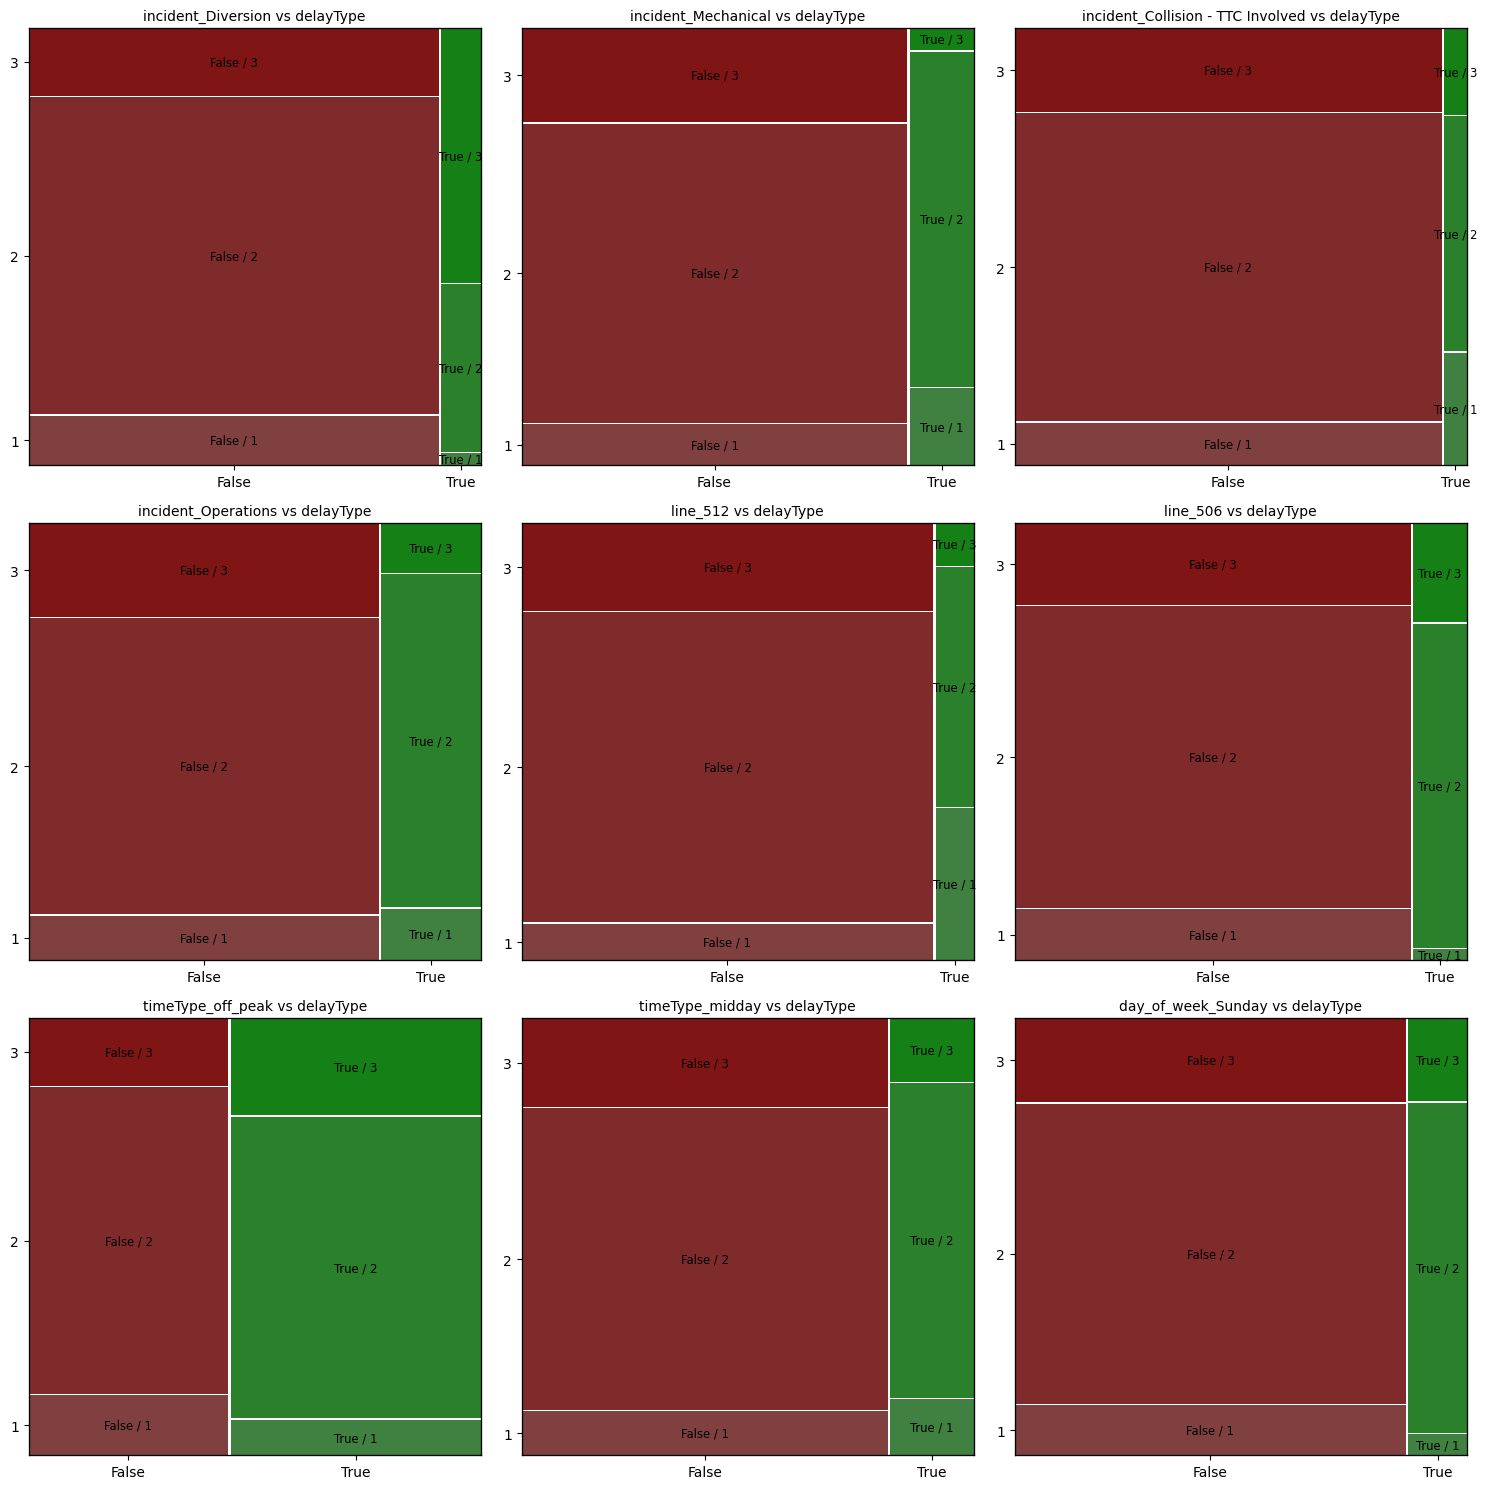

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Load your dataset
mosaic_df = df_cleaned.copy()

# List of features to plot against delayType
features_mosaic = [
    "incident_Diversion", "incident_Mechanical", "incident_Collision - TTC Involved",
    "incident_Operations", "line_512", "line_506", "timeType_off_peak", 
    "timeType_midday", "day_of_week_Sunday"
]

# Create a grid of subplots (3 rows x 3 columns for 9 plots)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Generate mosaic plots for each feature
for i, feature_mosaic in enumerate(features_mosaic):
    ax = axes[i]
    try:
        # Create a cross-tabulation
        cross_tab = pd.crosstab(mosaic_df[feature_mosaic], mosaic_df['delayType'])
        
        # Generate the mosaic plot
        mosaic(cross_tab.stack(), ax=ax, labelizer=lambda k: f"{k[0]} / {k[1]}")
        
        # Add a title to each subplot
        ax.set_title(f'{feature_mosaic} vs delayType', fontsize=10)
    except Exception as e:
        ax.set_title(f'Error with {feature_mosaic}', fontsize=10)
        print(f"Error generating plot for {feature_mosaic}: {e}")

# Remove any unused subplots if features < number of subplots
for j in range(len(features_mosaic), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Interpretation:

#### **Incident Diversion**, and **Line 506**

- The majority of the delays aren't related to these features. 
- However, when a delay involves them, it's more likely to be long delays (16 minutes or more) than other features.


#### **Incident types Mechanical, Collision - TTC Involved, Operations**, and **Line 512**, and **Time Type Midday**: 

- The majority of the delays aren't related to these features.
- However, when a delay involves them, it's more likely to be short delays (5 minutes or less) than other features. 


#### **Time Type Off Peak**: 

- It's more likely that a delay would fall in Off-Peak hours.
- When a delay falls in Off Peak hours, it's also more likely to be long delays (16 minutes or more) than other features.


#### **Sunday**

- The majority of the delays don't fall on a Sunday.
- However, when a delay falls on Sunday, it's more likely to be normal delays (between 6 and 15 minutes). 


---
# MODEL IMPROVEMENT - DIMENSIONALITY REDUCTION

REMOVE OVER 4,000 FEATURES TO ONLY KEEP TOP 50 FEATURES FOR X, AND RE-FIT MODEL.

In [46]:
# Select the top features
top_features = importance_df.head(50)


In [47]:
# Save the top 50 features as a CSV file
csv_file_path = "top_50_features.csv"  # Define your file name and path
top_features.to_csv(csv_file_path, index=False)  # Save the top 50 features without the index column
print(f"Top 50 features saved to {csv_file_path}")



Top 50 features saved to top_50_features.csv


In [48]:
# Assume 'top_features' is a DataFrame containing the top feature names
top_features_list = top_features['Feature'].tolist()

# Create new X and y based on reduced features
X_new = df_cleaned[top_features_list]
y_new = df_cleaned['delayType']  # Target variable

# Split data into training and test sets with stratification
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.3, stratify=y_new, random_state=42
)


In [101]:
# Save a DataFrame to a parquet file - for other ML experimentation
X_train_new.to_parquet('X_train_new.parquet')
y_train_new.to_csv('y_train_new.csv')

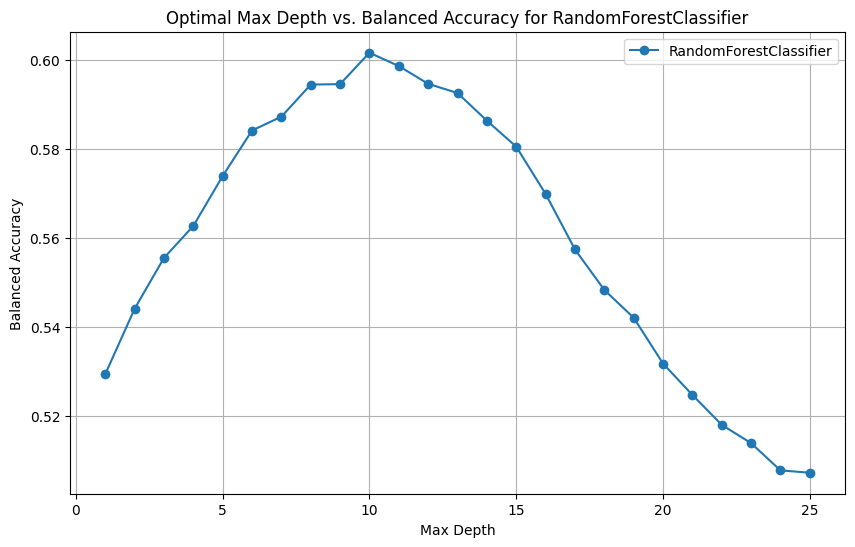

In [49]:
# Set up stratified cross-validation on the training set
stratified_cv_new = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the range for max_depth
max_depth_range_new = range(1, 26)
balanced_accuracy_depth_new = []

# Tune max_depth using stratified cross-validation
for max_depth in max_depth_range_new:
    rf_temp_new = RandomForestClassifier(max_depth=max_depth, class_weight='balanced', random_state=42)
    # Perform cross-validation with balanced accuracy scoring
    scores_new = cross_val_score(rf_temp_new, X_train_new, y_train_new, cv=stratified_cv_new, scoring='balanced_accuracy')
    mean_score_new = scores_new.mean()
    balanced_accuracy_depth_new.append(mean_score_new)

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range_new, balanced_accuracy_depth_new, label="RandomForestClassifier", marker='o')
plt.title("Optimal Max Depth vs. Balanced Accuracy for RandomForestClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.grid(True)  # Adds a grid for better readability
plt.show()


*Observation:* 
- Optimal Max Depth is about 10.

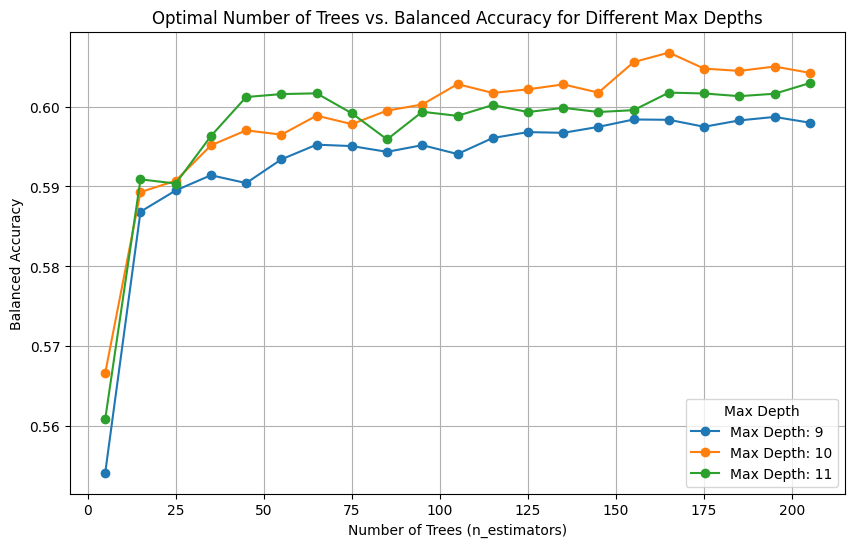

In [50]:
# Define the ranges for hyperparameters
max_depth_range_new = [9, 10, 11]  # Limited max_depth range for faster tuning
n_estimators_range_new = range(5, 210, 10)  # Range for n_estimators

# Initialize Stratified K-Fold and storage for results
stratified_cv_new = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_new = []  # To store results for each combination

# Perform grid search for max_depth and n_estimators
for max_depth in max_depth_range_new:
    balanced_accuracy_scores_new = []
    for n_estimators in n_estimators_range_new:
        rf_temp_new = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight='balanced',
            random_state=42
        )
        # Perform cross-validation with balanced accuracy scoring
        scores_new = cross_val_score(
            rf_temp_new, X_train_new, y_train_new, cv=stratified_cv_new, scoring='balanced_accuracy'
        )
        mean_score_new = scores_new.mean()
        balanced_accuracy_scores_new.append(mean_score_new)
    
    # Store results for this max_depth
    results_new.append((max_depth, balanced_accuracy_scores_new))

# Plot the results for each max_depth
plt.figure(figsize=(10, 6))
for max_depth, scores_new in results_new:
    plt.plot(
        n_estimators_range_new,
        scores_new,
        label=f"Max Depth: {max_depth}",
        marker='o'
    )

plt.title("Optimal Number of Trees vs. Balanced Accuracy for Different Max Depths")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Balanced Accuracy")
plt.legend(title="Max Depth")
plt.grid(True)  # Adds grid for better readability
plt.show()


*Observation:*
- Optimal max-depth is 10. 
- Optimal number of trees is about 162 - 168 trees, after which the incremental benefit is negligible.

In [52]:
# Define the parameter grid with max_depth fixed at 10
param_grid_new = {
    'n_estimators': [162, 165, 168],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest Classifier with fixed max_depth
clf_new = RandomForestClassifier(max_depth=10, class_weight='balanced', random_state=42)

# Initialize StratifiedKFold for stratified cross-validation
stratified_cv_new = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with StratifiedKFold
grid_search_new = GridSearchCV(
    estimator=clf_new,
    param_grid=param_grid_new,
    cv=stratified_cv_new,
    scoring='balanced_accuracy',
    n_jobs=-1  # Use all available processors
)

# Fit GridSearchCV to the data
grid_search_new.fit(X_train_new, y_train_new)

# Print the best parameters and score
print("Best parameters found: ", grid_search_new.best_params_)


Best parameters found:  {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 168}


In [53]:
# Define the best parameters found from GridSearchCV
best_params_new = {
    'min_samples_leaf': 2,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 2,  # Minimum number of samples required to split an internal node
    'n_estimators': 168,  # Number of trees in the forest
    'max_depth': 10  # Maximum depth of the tree
}

# Initialize and fit the Random Forest Classifier with the best parameters
best_clf_new = RandomForestClassifier(**best_params_new, class_weight='balanced', random_state=42)
best_clf_new.fit(X_train_new, y_train_new)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, n_estimators=168, random_state=42)

In [54]:
# Fit the model to the test set
y_pred_new = best_clf_new.predict(X_test_new)


In [55]:
# Get the feature importances from the trained Random Forest model
feature_importances_new = best_clf_new.feature_importances_

# Use the feature names from the preprocessed data
features_new = X_new.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df_new = pd.DataFrame({'Feature': features_new, 'Importance': feature_importances_new})

# Sort the DataFrame by importance in descending order
importance_df_new = importance_df_new.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df_new)


                              Feature  Importance
0                  incident_Diversion    0.187724
1                            line_512    0.133052
2                 incident_Mechanical    0.065904
3                   timeType_off_peak    0.048122
5                            line_506    0.041885
15             seasonType_Summer 2024    0.033466
6                            line_505    0.029119
4   incident_Collision - TTC Involved    0.026024
11                           line_510    0.025751
7                 incident_Operations    0.025631
13             seasonType_Spring 2023    0.025341
8         incident_Emergency Services    0.023973
9                  day_of_week_Sunday    0.023630
12             incident_General Delay    0.022515
20                           line_501    0.018582
14                   incident_Held By    0.017158
21        incident_Utilized Off Route    0.015832
10                    timeType_midday    0.015404
24             seasonType_Winter 2023    0.013910


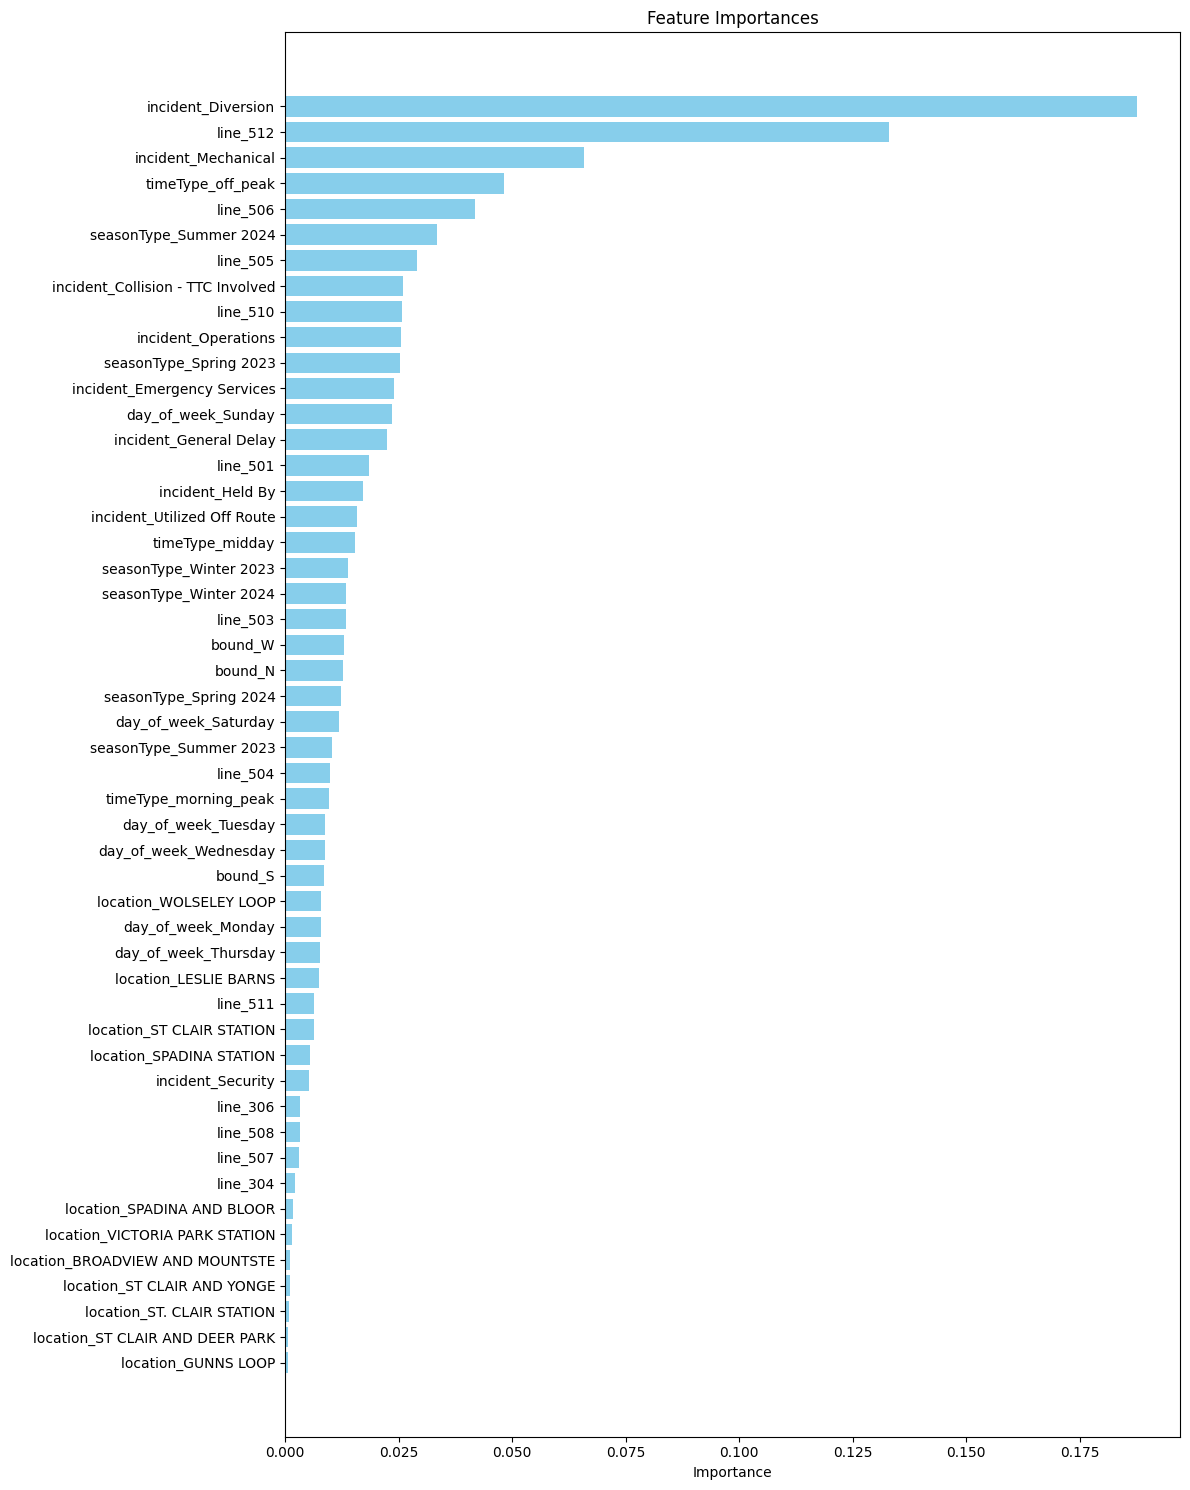

In [56]:
# Plot all feature importances
plt.figure(figsize=(12, 15))  # Adjust the figure size to accommodate all features
plt.barh(
    importance_df_new['Feature'][::-1],  # Reverse the order for the bar plot
    importance_df_new['Importance'][::-1],
    color='skyblue'
)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()


In [57]:
# Generate the classification report
class_report_new = classification_report(y_test_new, y_pred_new)
print("Classification Report:\n", class_report_new)

# Calculate and print the balanced accuracy score
balanced_acc_new = balanced_accuracy_score(y_test_new, y_pred_new)
print(f"\nBalanced Accuracy: {balanced_acc_new:.2f}")



Classification Report:
               precision    recall  f1-score   support

           1       0.32      0.64      0.43       583
           2       0.83      0.56      0.67      3832
           3       0.38      0.62      0.47      1056

    accuracy                           0.58      5471
   macro avg       0.51      0.61      0.52      5471
weighted avg       0.69      0.58      0.60      5471


Balanced Accuracy: 0.61


### **INTERPRETATION:**

- **Balanced Accuracy:** The new model performs 2% better than the previous model (61% vs 59%). 

- **Precision, Recall, and F1-score (ie. the harmonic mean of precision and recall):** 
    

    - **Precision scores**: 
    
        - Overall the new model has the same performance as the previous model:

            - 2% worse for Delay Type 1 (32% vs 34%) 
            - 1% improvement for Delay Type 2 (83% vs 82%)
            - 1% improvement for Delay Type 3 (38% vs 37%)
        
        - This means that there are a lot of false positives for the minority classes (Delay Types 1 and 3), but very few false positives for the majority class (Delay Type 2). 


    - **Recall scores**: 
    
        - Overall the new model performs slightly better than the previous model:

            - 5% improvement for Delay Type 1 (64% vs 59%) 
            - 3% worse for Delay Type 2 (56% vs 59%)
            - 2% improvement for Delay Type 3 (62% vs 60%)
        
        - However, there are still many missed true positive cases, but it does perform above average. 

       
    - **F1 scores**: 
        
        - Overall the new model performs slightly worse than the previous model:

            - 1% worse for Delay Type 1 (43% vs 44%) 
            - 2% worse for Delay Type 2 (67% vs 69%)
            - 1% improvement for Delay Type 3 (47% vs 46%)
        
        - This means that the model is not effective at correctly identifying positive instances while minimizing false positives - especially for the minority classes.


### **CONCLUSION:**

- Reducing dimensions (from > 4,300 features to 50 features) gives a slightly better 'balanced accuracy' score (at 61%) and slightly better 'recall' scores for the minority classes (Delay Types 1 and 3) than the previous model. 
- The new model performs very well at 'precision score' for the majority class (Delay Type 2 - normal delays, between 6 and 15 minutes), giving very few false positives for this class.  




In [58]:
# Ensure best_clf_new is a trained RandomForestClassifier
explainer_new = shap.TreeExplainer(best_clf_new)

# Ensure X_test_new is properly formatted and matches training features
shap_values_new = explainer_new.shap_values(X_test_new)


In [59]:
# SHAP values for delayType = 1
shap_values_class1_new = shap_values_new[0]

# SHAP values for delayType = 2
shap_values_class2_new = shap_values_new[1]

# SHAP values for delayType = 3
shap_values_class3_new = shap_values_new[2]

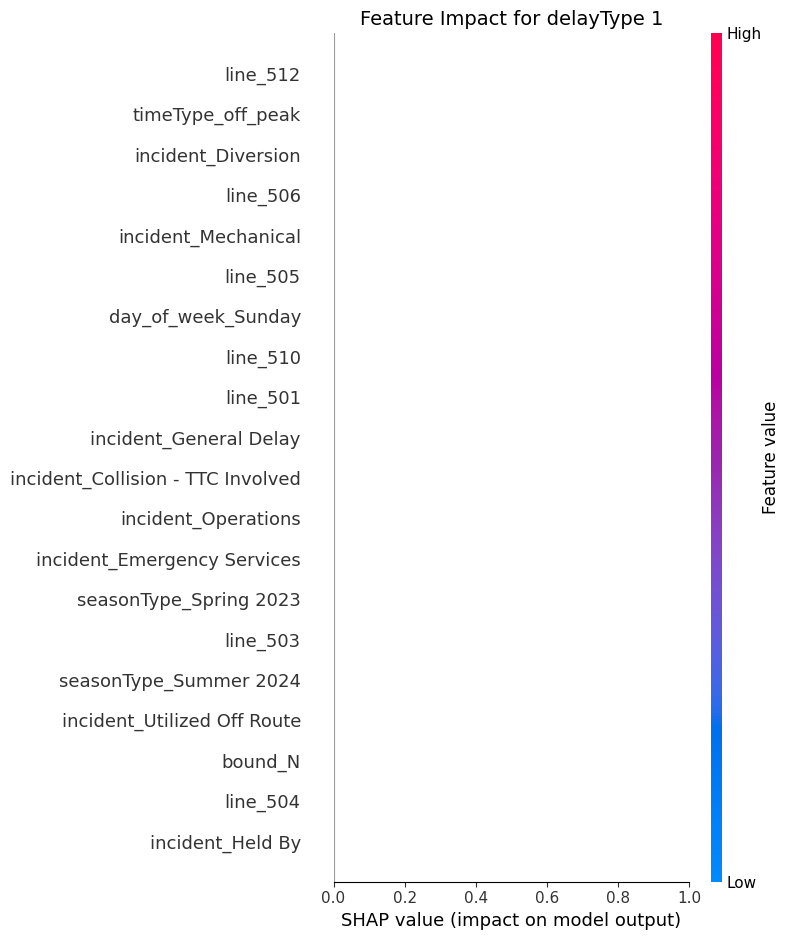

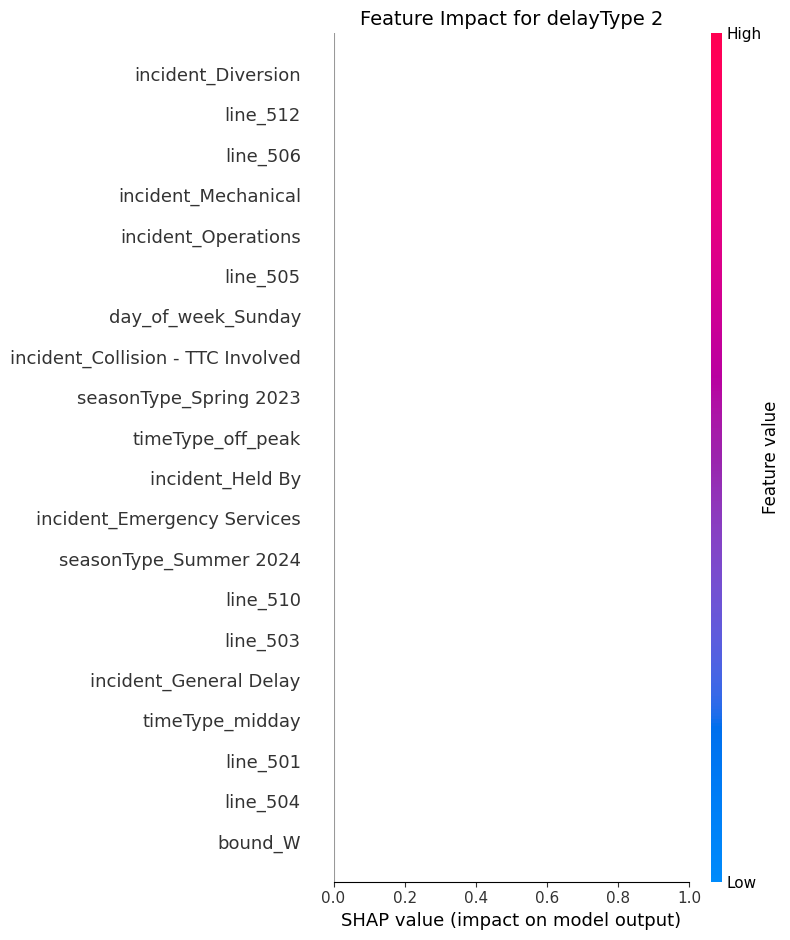

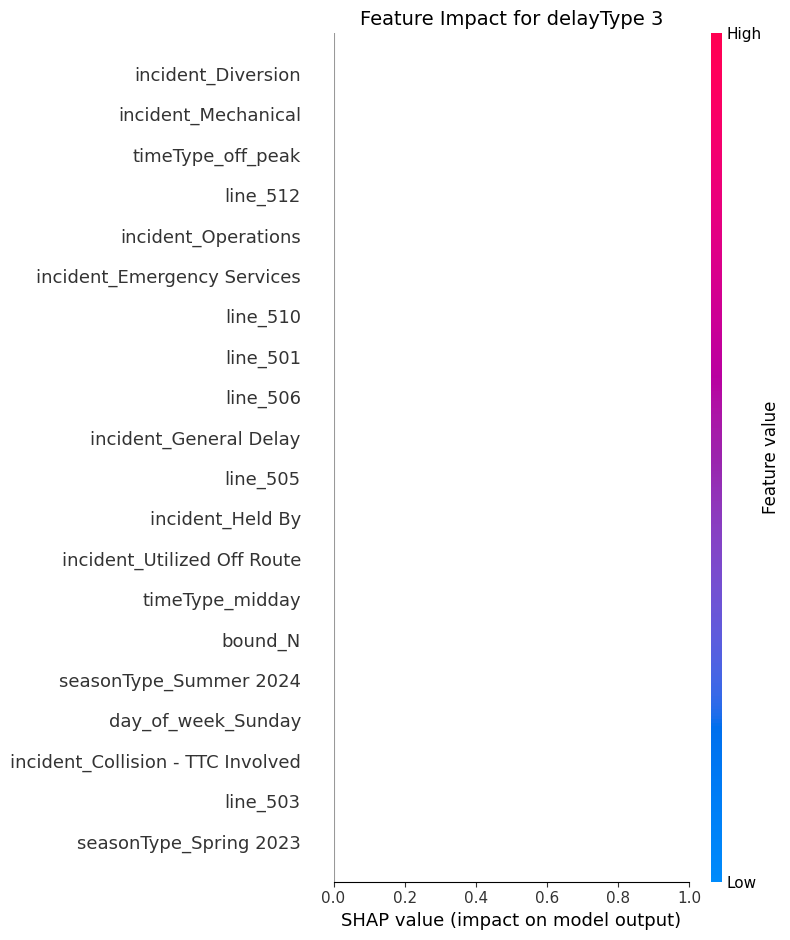

In [60]:
# Define SHAP values and class labels
shap_values_classes = [shap_values_class1_new, shap_values_class2_new, shap_values_class3_new]
class_labels = ["delayType 1", "delayType 2", "delayType 3"]

# Generate beeswarm plots dynamically
plt.close('all')
for shap_values_class, label in zip(shap_values_classes, class_labels):
    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_values_class, 
        X_test_new, 
        plot_type="beeswarm", 
        show=False
    )
    plt.gca().set_title(f"Feature Impact for {label}", fontsize=14)
    plt.tight_layout()
    plt.show()


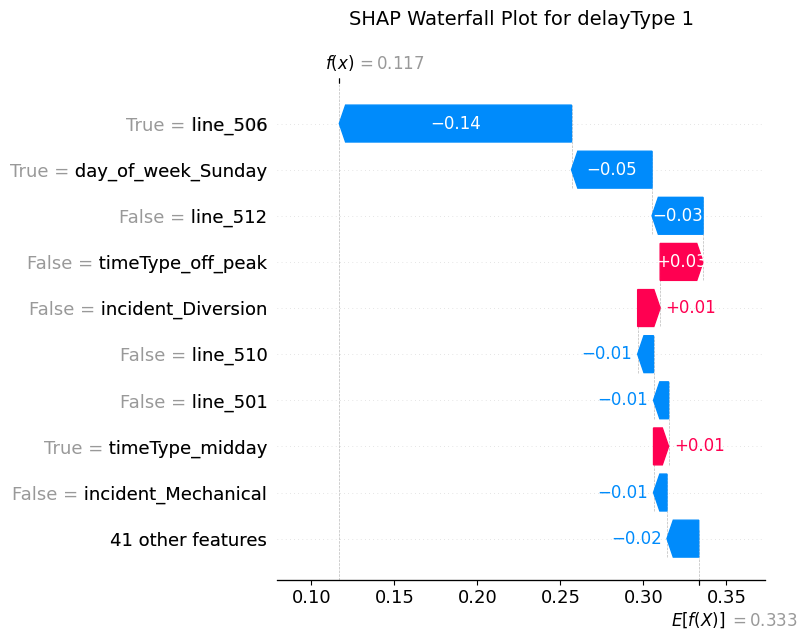

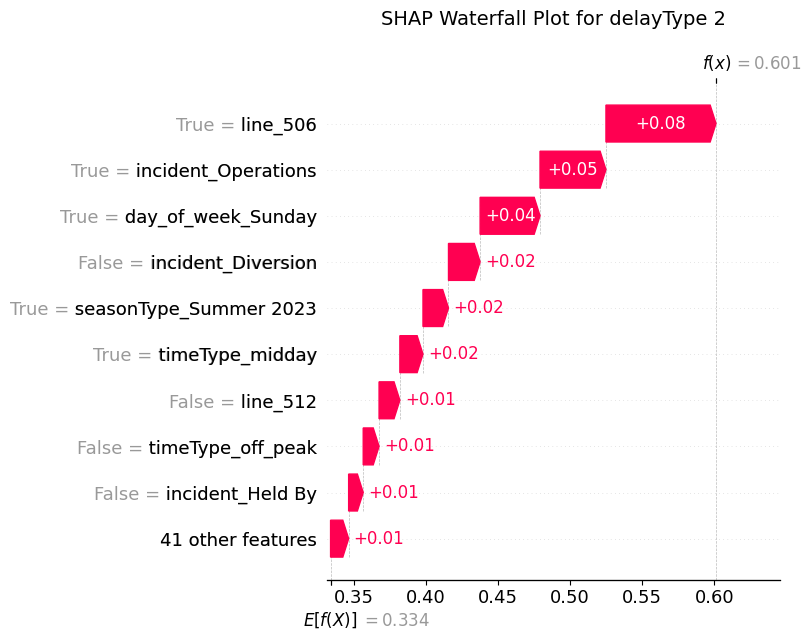

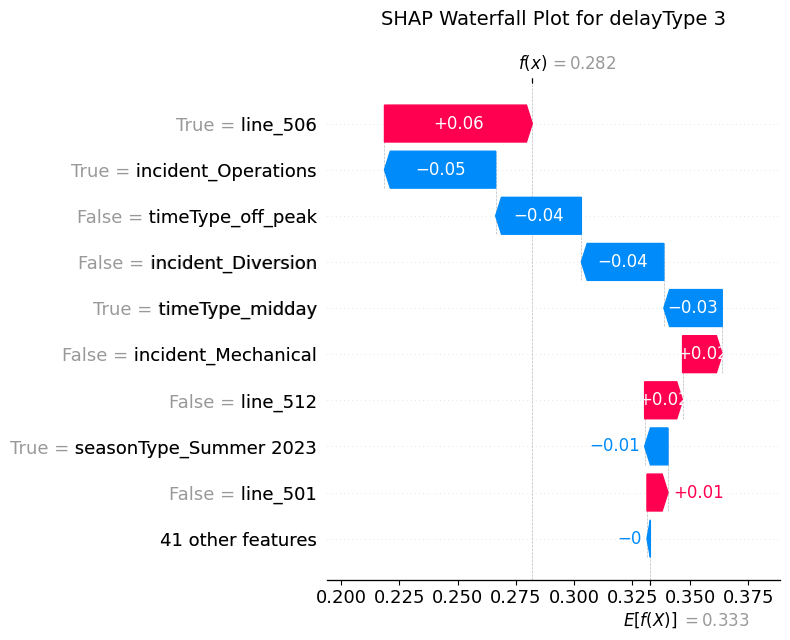

In [61]:
# Sample index for demonstration
sample_index_new = 0

# Store them in a list of arrays
shap_values_list_new = [shap_values_class1_new, shap_values_class2_new, shap_values_class3_new]

# Iterate through each class to create waterfall plots
for i, shap_values_class in enumerate(shap_values_list_new):
    # Create SHAP explanation object for the current class
    explanation_new = shap.Explanation(
        values=shap_values_class[sample_index_new],
        base_values=explainer_new.expected_value[i],  # Base value for the current class
        data=X_test_new.iloc[sample_index_new],
        feature_names=X_test_new.columns
    )
    
    # Generate the waterfall plot with a title directly inside the plot
    plt.figure(figsize=(8, 6))  # Optional: Set figure size
    shap.waterfall_plot(explanation_new, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot for delayType {i+1}", fontsize=14, pad=20)  # Add a title to the plot
    plt.tight_layout()  # Ensure layout fits well
    plt.show()  # Display the plot


In [62]:
# Save the trained model to a pkl file
model_file_path = "RF.pkl"
joblib.dump(best_clf_new, model_file_path)
print(f"Trained model saved to {model_file_path}")



Trained model saved to RF.pkl


---

# *STREAMLIT - WEB APP*

In [99]:
def assign_category(feature):
    if "day_of_week_" in feature:
        return "Day of Week"
    elif "line_" in feature:
        return "Line"
    elif "seasonType_" in feature:
        return "Season"
    elif "timeType_" in feature:
        return "Time Type"
    elif "incident_" in feature:
        return "Incident Type"
    elif "location_" in feature:
        return "Location"
    elif "bound_" in feature:
        return "Bound"
    else:
        return "Other"


In [100]:
# Extract top 50 features and create a new DataFrame
top50_new_rf = importance_df_new.head(50).copy()

# Assign categories
top50_new_rf['Category'] = top50_new_rf['Feature'].apply(assign_category)

# Save to CSV
top50_new_rf.to_csv("top50_new_rf.csv", index=False)

